# Lidar data × Python Tutorial Session 1. ～`.las`ファイルを扱う最初のステップ～

チュートリアルではPythonを使用してLidarのデータ処理について学んでいきます。第一回のこのセッションでは、Lidar計測データフォーマットの1つである`.las`を題材に、実際のPythonコードを実行しながら進んでいきましょう。
---

Section1.
 - 外部ライブラリのインストールと今回使用するライブラリのインポート

Section2.
 - データの読み込みとメタデータを確認する

 - データの範囲を確認する

 - 空間参照系の設定

 - データの保存

Section3.
 - ラスターデータとは何なのか

 - DTM(Digital Terrein Model : 数値地形モデル)の作成アルゴリズムとパラメーターによる成果の違い

Section4.
 - DSM(Digital Terrein Model : 数値表層モデル)の作成

Section5.
 - CHM(Cannopy Height Model : 樹冠高モデル)の作成


おわりに.

Section?.
 - データのビジュアライズ

Section?.
 - 外れ値の除去

 - 点群データの間引き（リサンプリング）


# Section1.
このチュートリアルでは`C++`のライブラリである`PDAL(Point Data Abstraction Library)`を使用して点群データを処理していきます。以下は生成AIで作成したPDALについての要約です。

 - PDALは、LiDARデータを含む点群データを処理するためのオープンソースのライブラリおよびアプリケーションです。

 - GDALライブラリがラスターとベクターデータを処理するのと同様に、PDALは点群データを操作します。

 - PDALは、点群データの変換、フィルタリング、クエリ、結合などのさまざまな操作を行うことができます。



## 外部ライブラリのインストール
---
点群データを扱う為のライブラリをインストールする必要があります。これはNotebookを閉じるたびにリセットされてしまうので、面倒ですが毎回インストールする必要があります。


In [1]:
# 最初にこのセルを実行すると、一度セッションが再起動される。再起動されたら、次のセルを実行してもよい。
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:20
🔁 Restarting kernel...


In [2]:
# 今回のチュートリアルに必要なライブラリをインストールする。
# これも実行すると再起動がかかるかもしれないが、その後下のセルを実行する事が出来る。
!conda update -y -n base -c defaluts conda
!conda install --channel conda-forge pdal
!pip install PDAL open3d polars japanize_matplotlib folium mapclassify pyproj

Channels:
 - defaluts
 - conda-forge
Platform: linux-64

UnavailableInvalidChannel: HTTP 404 NOT FOUND for channel defaluts <https://conda.anaconda.org/defaluts>

The channel is not accessible or is invalid.

You will need to adjust your conda configuration to proceed.
Use `conda config --show channels` to view your configuration's current state,
and use `conda config --show-sources` to view config file locations.


Channels:
 - conda-forge
Platform: linux-64
Solving environment: \ | / - \ | / done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.3.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - pdal


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    aws-c-auth-0.7.17          |       he0b1f16_2   

## ライブラリのインポートとGoogleDriveの接続
---
GoogleColabでは直接データをアップロードする事も可能ですが、処理時間が掛かります。今回は事前に自分のGoogleDriveに使用する`.las`ファイルとオルソ画像を保存しておき、そこから読み込んで使用しましょう。


In [2]:
import json
import os
from pprint import pprint

import geopandas as gpd
# from google.colab import drive
import japanize_matplotlib
from IPython.display import display, Image
from matplotlib import pyplot as plt
import numpy as np
import open3d
import pdal
import polars as pl
import pyproj
import shapely
from shapely.plotting import plot_polygon

# GoogleDriveをマウント
# drive.mount('/content/drive')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Section2.
このセクションでは`.las`ファイルにどんなデータが保存されているのかを見て見ましょう。`PDAL`は`CLI(Command Line Interface)`で操作するのが一般的だと思いますが、今回は`GoogleColab`を使用しているという事もあり、`Python`から呼び出して使用してみます。

処理する内容や順番は`pipeline`に記述します。`pipeline`ではデータの入出力や処理の流れを記述し、`.json`フォーマットのファイルに書き出し、それを読み込んで使用します。しかし面倒なので、今回はセルの中にDict型のオブジェクトとして変数に代入し、それを`json.dumps`モジュールでjson文字列化して使用しましょう。


## データの読み込みとメタデータの確認
---
まずは`pipeline`の第一歩としてデータの読み込みを行います。
`pipeline`の記述方法について、簡単にはセルの中にコメントを書いていますが、詳しくは公式のドキュメントを読んだ方がいいでしょう。

 - [PDAL Documents](https://pdal.io/en/2.7-maintenance/)

 - [Pipeline](https://pdal.io/en/2.7-maintenance/pipeline.html)


In [3]:
# GoogleDrive内にある`.las`ファイルまでのパス
# INPUT_FILE = r'/content/drive/MyDrive/notebooks/LearnLidar_JFF/Izu.las'
INPUT_FILE = r'./LearnLidar_JFF/Izu.las'

# Pipeline処理をDict型のオブジェクトに記述する。
sentence = {
    'pipeline': [
        { # データを読み込む処理
            'type' : 'readers.las', # <- .の後はフォーマットを指定、今回は`las`
            'filename': INPUT_FILE # <- GoogleDrive内にある`.las`ファイルまでのパス
        }
    ]
}
# Dict型のオブジェクトをJSON文字列に変換
json_sentence = json.dumps(sentence)


# PipelineのクラスにJSON文字列を渡し、インスタンスを作成する。
pipeline = pdal.Pipeline(json_sentence)
# Pipeline処理の実行
pipeline.execute()


# `.las`に入力されているメタデータの取得と表示
meta_data = pipeline.metadata
pprint(meta_data)

{'metadata': {'filters.merge': {},
              'readers.las': {'comp_spatialreference': '',
                              'compressed': False,
                              'copc': False,
                              'count': 22350278,
                              'creation_doy': 0,
                              'creation_year': 2023,
                              'dataformat_id': 3,
                              'dataoffset': 227,
                              'filesource_id': 0,
                              'global_encoding': 0,
                              'global_encoding_base64': 'AAA=',
                              'header_size': 227,
                              'major_version': 1,
                              'maxx': -124310,
                              'maxy': 33250,
                              'maxz': 681.46,
                              'minor_version': 2,
                              'minx': -124530,
                              'miny': 33100,
              

上記で出力したデータを見てみましょう。出力の下側にある<b>`spatialreference`</b>には何も入力されていないのが確認できます。

<b>`Spatial Reference System（SRS : 空間参照系）`</b>とは地理情報を扱う為のルールの様なもので、`SRS`によって原点の位置が変化します。この`SRS`は<b>Coordinate Reference System（CRS : 座標参照系）</b>と表記されている場合もあります。

詳しく説明すると長くなるので、簡単に説明すると、大きく2つのグループに分ける事が出来ます。
1. **地理座標系** ...
    地理座標系の原点は地球の重心にあり、その重心からの角度で座標を表現するものです。通常よく目にする経緯度(経度: 140.23567, 緯度: 39.00345)などがこれにあたり、地球上のどこにいても座標を特定する事が可能な非常に広域な座標系です。
    しかしデメリットとして距離や面積を正確に求めるのが難しくなります。

    有名な地理座標系には、GPSに使用されている**`WGS84(World Geodetic System 1984 : 世界測地系1984)`**があります。

2. **投影座標系** ...
    投影座標系の原点は様々な場所にあり、データの範囲などによってその原点を選択する事が出来ます。これは原点からの距離で座標を表現し、距離や面積を正確に求める事が出来ます。
    都道府県を跨ぐような大きな範囲のデータセットであれば`UTM座標系`を選択しますが、今回のデータは静岡県内の局所的な範囲なので、そこに原点が近い**`JGD2011 Ⅷ（EPSG:6676）`**を設定すると良いでしょう。


 - [EPSGコード一覧](https://lemulus.me/column/epsg-list-gis)

 - [日本で使用される座標系](https://www.esrij.com/gis-guide/coordinate-and-spatial/coordinate-system-japan/)



## データの範囲を確認する
---
空間参照系を設定する前に、本当にそのまま設定しても良いのか確認してみましょう。

メタデータを見ると、データ範囲の座標が書き込まれています。この情報を取り出して、`Polygon`のオブジェクトを作成し、動的なMapに投影して確認してみましょう。

In [48]:
# metadata内から座標の最小値と最大値を取得
meta_data_readers = meta_data.get('metadata').get('readers.las')
max_x = meta_data_readers.get('maxx')
max_y = meta_data_readers.get('maxy')
min_x = meta_data_readers.get('minx')
min_y = meta_data_readers.get('miny')

# shapely.Polygonのオブジェクトを作成
box = shapely.box(*[min_x, min_y, max_x, max_y])

count = meta_data_readers.get('count')
report = \
f"""
計測範囲面積   : {box.area / 10_000}ha
計測点数       : {'{0:,}'.format(count)}
1㎡あたりの点数: {round(count / box.area, 1)} 
"""
print(report)


計測範囲面積   : 3.3ha
計測点数       : 22,350,278
1㎡あたりの点数: 677.3 



In [49]:
# geopandas.GeoDataFrameに格納し、OpenStreetMapに重ねて見る。
# 読み込みに少し時間がかかりますが、動的なMapを見る事が出来ます。
IN_CRS = 'EPSG:6676'

gdf = gpd.GeoDataFrame(geometry=[box], crs=IN_CRS)
gdf.explore()

Mapで確認するとわかる様に、岐阜県の山中に投影されてしまいました。
平面直角座標系は少しややこしいですが、多くの人がイメージする数学のXY座標（横軸がX、縦軸がY）と異なり、横軸がYで縦軸がXとなります。
国交省のWebサイトには以下の様に書かれています。

```
座標系のＸ軸は、座標系原点において子午線に一致する軸とし、真北に向う値を正とし、座標系のＹ軸は、座標系原点において座標系のＸ軸に直交する軸とし、真東に向う値を正とする。
```
つまり北方向は+Y、東方向は+Xとなります。

この`.las`も上記の様にXYが逆になっていたのかもしれません。入れ替えてもう一度動的なMapに投影させてみましょう。




In [47]:
reversed_box = shapely.box(*[min_y, min_x, max_y, max_x])
reversed_gdf = gpd.GeoDataFrame(geometry=[reversed_box], crs=IN_CRS)
reversed_gdf.explore()

今度は間違いなく、伊豆の山中に投影する事ができました。このデータを取得した場所の概要は知りませんが、恐らく**座標系は`JGD2011 Ⅷ（EPSG:6676）`**であり、**データのXYが逆になっている**という事がわかりました。

## 空間参照系の設定とデータの保存
---
ここまでで空間参照系とデータのXY座標が逆になっている事がわかりました。平面直角座標系ではXYが数学座標と逆である事は正しいのですが、GISなどでデータを扱う場合は、数学座標の考え方とそろえた方が扱いやすいでしょう。

次はこのデータに空間参照系を定義し、XY座標を入れ替えて保存してしまいましょう。この処理は、データを読み込み、メタデータを確認した時と同じように、`pipeline`で行う事が出来ます。

上のセルで既に読み込んでいるデータからpolars.DataFrameを作成し、DataFrameを見て見ましょう。下のセルで実行したDataFrameを見ると、`X`が1列目、`Y`が2列目に入力されている事が確認できます。`pipeline`上でこの列を入れ替える事が出来ます。

In [26]:
pl.DataFrame(pipeline.arrays[0]).head(3)

X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,Synthetic,KeyPoint,Withheld,Overlap,ScanAngleRank,UserData,PointSourceId,GpsTime,Red,Green,Blue
f64,f64,f64,u16,u8,u8,u8,u8,u8,u8,u8,u8,u8,f32,u8,u16,f64,u16,u16,u16
-124484.26,33100.84,637.23,682,0,0,0,0,1,0,0,0,0,0.0,0,29,0.0,23130,31097,23901
-124483.58,33104.73,637.76,1024,0,0,0,0,1,0,0,0,0,0.0,0,29,0.0,32125,37522,26214
-124481.53,33104.46,636.75,986,0,0,0,0,1,0,0,0,0,0.0,0,29,0.0,10537,16191,13364


In [27]:
proj = pyproj.Proj(IN_CRS)
IN_SRS_PS = proj.to_proj4()

OUT_FILE_LAS = 'Izu_proj.las' # <- 出力するファイル名
OUT_FILE_LAS = os.path.join(os.path.dirname(INPUT_FILE), OUT_FILE_LAS)

sentence = {
    'pipeline': [
        { # データを読み込む処理
            'type' : 'readers.las',
            'filename': INPUT_FILE,
            # 'default_srs': IN_CRS
            # 上記だとEPSGを探せずに上手くいかない場合がある。以下はエラー文
            # RuntimeError: Could not import coordinate system 'EPSG:6676': PROJ: proj_create_from_database: Open of /usr/local/share/proj failed.
            'default_srs': IN_SRS_PS
        },
        { # データの1列目と2列目を入れ替える
            "type": "filters.reprojection",
            "in_srs": IN_SRS_PS,
            "out_srs": IN_SRS_PS,
            "in_axis_ordering": "2, 1"
        },
        { # '.las'フォーマットで出力する
            'type': 'writers.las',
            'filename': OUT_FILE_LAS
        }
    ]
}
# Dict型のオブジェクトをJSON文字列に変換
json_sentence = json.dumps(sentence)


# PipelineのクラスにJSON文字列を渡し、インスタンスを作成する。
pipeline = pdal.Pipeline(json_sentence)
# Pipeline処理の実行
pipeline.execute()

22350278

# Section3.
---
3Dでビジュアライズするのであれば3次元の点群データのままの方がいいでしょう。しかし、樹頂点を検出するなどの場合であれば2次元のデータに変換する方が計算が簡単になります。

このセクションでは`.las`ファイル内に保存している点群データから**`DTM(Digital Terrein Model：数値地形モデル)`**を作成します。



## Raster(ラスター）とは何なのか
---
DTMなどをファイルとして保存する場合は`.tif(.tiff)`ファイルとして保存する事が多いでしょう。**`Tiff(Tagged Image File Format)`**とは画像データを保存する為に使用するファイル形式です。非圧縮または可逆圧縮でファイルを保存するので、画像の品質を落とさずに高解像度の画像を扱う事が出来ます。つまりキレイな画像なのですが、GISではこれらの画像データを**`Raster Data(ラスターデータ)`**と呼びます。

DTMの処理をする前に、まずはこの画像データについて解説していきます。この場で各フォーマットに対し詳しい解説をするわけではありません。そもそも画像とはどんなデータ構造になっているのか、について解説していきます。これがわかる方はここを飛ばしても構いません。

### 画像の概要
PCなどで画像ファイルの詳細を見ると、画像のサイズが書かれていると思います。

大きさ: 100 × 200

幅　　: 100

高さ　: 200

これは行方向（横）にいくつのセルが並んでいるか、列方向にいくつのセルが並んでいるか、を表します。

セルとは画像を構成する小さな四角いマスの事です。

Excelで考えるとわかりやすいかと思います。`Sheet1`に対して100行200列の範囲に罫線を引き、列幅を調節して、辺の長さをそろえると画像の骨組みを作る事が出来ます。

Excelでも1つのセルには数値が1つしか入りません、句読点を入れてしまうとそれは数値ではなく数字の文字列になります。画像も同じ様に、1つのセルには1つの数値が入力されており、この数値の大小で画像は色を表現しています。


### 白黒画像の構成
---
一番イメージしやすいのが、白黒画像です。この構成はDTMなどと同じなので、ここを読んで理解を深めて下さい。

白黒画像は上記で解説したとおり、数値が入力された2次元行列のデータとして考える事が出来ます。

実際に行列を用意して可視化してイメージを確認してみましょう。以下のコードでは実際に白黒画像を作成して、そのデータを可視化させています。数値が高い場所は白く、数値が低い場所は黒く表示されているのがわかると思います。

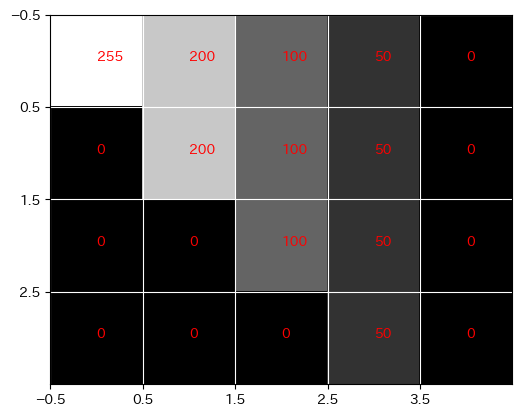

In [28]:
# ここでは8bit(2の8乗)の画像を例に考えます。
# 下の`img`に代入した配列が画像のデータです。
img = np.array([
    [255, 200, 100, 50, 0],
    [0  , 200, 100, 50, 0],
    [0  ,   0, 100, 50, 0],
    [0  ,   0,   0, 50, 0],
])

plt.imshow(img, cmap='gray')
for xc in list(range(0, 5)):
    for yc in list(range(0, 4)):
        plt.text(xc, yc, img[yc][xc], color='red')

plt.yticks(np.arange(-0.5, 3.5, 1))
plt.xticks(np.arange(-0.5, 4.5, 1))
plt.grid(color='white');

ラスターデータは、上記のように行と列の格子状に並んだセル（ピクセル）で構成されます。各セルには数値が入力されており、この数値で要素を表現します。このデータをメッシュデータ、またはグリッドデータと呼ぶ事もあります。DTMの場合はこのセルに地形の高さ（m）が入力されています。

## DTMの作成
---
実際に点群データからDTMを作成してみたいのですが、ここで問題が生じます。点群データの中には地面のデータだけではなく、様々な物体に反射した点群が含まれています。

イメージを確認する為に、実際に点群データの範囲内に1m幅のサンプル帯を作成し、そこにある点群を可視化してみましょう。

In [38]:
# 出力した新たなデータを読み込む
sentence = {
    'pipeline': [
        {
            'type': 'readers.las',
            'filename': OUT_FILE_LAS,
        }
    ]
}
json_sentence = json.dumps(sentence)

pipeline = pdal.Pipeline(json_sentence)
pipeline.execute()

# DataFrame化
ary = pipeline.arrays[0]
df = gpd.GeoDataFrame(ary)
df.head(3)

,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,Synthetic,KeyPoint,Withheld,Overlap,ScanAngleRank,UserData,PointSourceId,GpsTime,Red,Green,Blue
0,33100.84,-124484.26,637.23,682,0,0,0,0,1,0,0,0,0,0.0,0,29,0.0,23130,31097,23901
1,33104.73,-124483.58,637.76,1024,0,0,0,0,1,0,0,0,0,0.0,0,29,0.0,32125,37522,26214
2,33104.46,-124481.53,636.75,986,0,0,0,0,1,0,0,0,0,0.0,0,29,0.0,10537,16191,13364


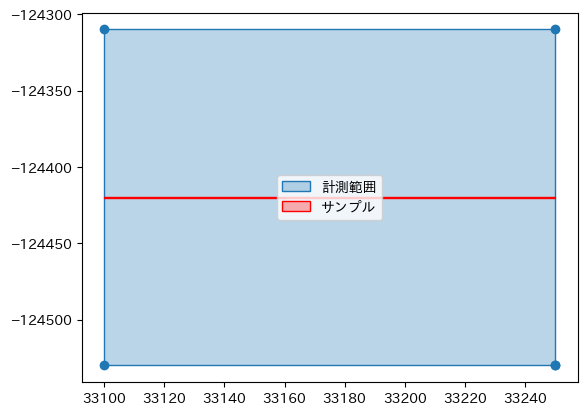

In [52]:
# 帯の作成
max_x, min_x = df['X'].max(), df['X'].min()
max_y, min_y = df['Y'].max(), df['Y'].min()
sample_y = (max_y - min_y) / 2 + min_y
sample_box = (
    shapely
    .LineString([
        [min_x, sample_y],
        [max_x, sample_y]
    ])
    .buffer(0.5, cap_style='flat')
)

box = shapely.box(min_x, min_y, max_x, max_y)
# 帯の可視化
fig, ax = plt.subplots()
plot_polygon(box, ax=ax, label='計測範囲')
plot_polygon(sample_box, color='red', add_points=False, ax=ax, label='サンプル')
ax.legend()

In [59]:
# geopandas.GeoSeriesの作成
geoms = gpd.points_from_xy(x=df['X'], y=df['Y'], z=df['Z'], crs=IN_SRS_PS)

# サンプル内のデータに絞り込む
select_geoms = geoms[sample_box.intersects(geoms)]
print(f"サンプル内の点数: {len(select_geoms)}")

サンプル内の点数: 144483


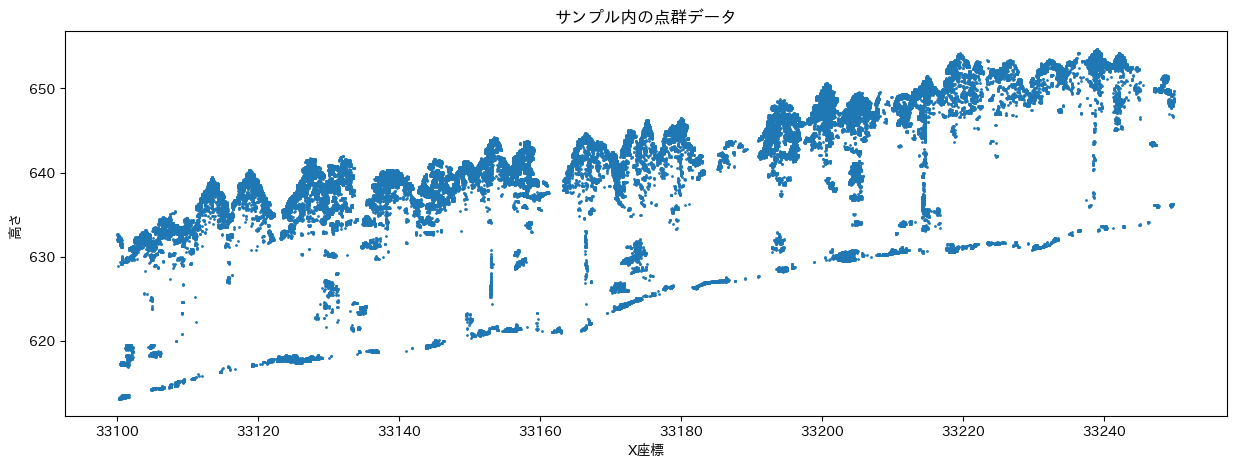

In [66]:
# データの可視化
x = select_geoms.x
z = select_geoms.z
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(x, z, s=1)
ax.set_title('サンプル内の点群データ')
ax.set_xlabel('X座標')
ax.set_ylabel('高さ');

上記の散布図を見て見ると樹冠や幹、地面など様々なデータが取得できている事が確認できます。

しかし`DTM`を作成する場合は、この中から地面のデータだけを抽出する必要があります。

どの様にすれば地面のデータだけを抽出する事が出来るのでしょうか。

### CSF(Cloth Simulation Filter)アルゴリズムによる点群分類
---
ここでは`Cloud Compare`でも使用されている`CSF`について簡単に解説します。

`CSF`は点群データを「地面点」か「非地面点」に分類する為のアルゴリズムです。このアルゴリズムではクロス（Cloth : 布）を使用して地面を分類します。

<b>1. 計測データの反転 ... </b>まずは計測した点群データの上下を反転させます。レーザーは光なので、物体を透過する事はありません。したがって、樹冠や幹、地面などの表面に当たり反射したものが計測され記録されています。このデータを反転させ、ある断面を見てみると、物体があった場所には穴のような凹みが現れるでしょう（下図参照）。

<b>2. クロスシュミレーション ... </b>反転したデータに対して、布を被せる様な計算を行う事で地面の位置を予測します。データを反転した際に出来た凹みは、現実世界と同じ様に布を被せても布が凹みの穴に落ちて行くことはありません。

<b>3. 布の大きさ（解像度 : resolution） ... </b>単純に全体に対して布を被せるわけではありません。布の大きさを指定し（例えば 1m × 1m）その布をずらしながら、何度も被せて全体の分類を行います。この布の大きさは非常に重要で、小さくし過ぎると布が凹みの中に落ちてしまいますし、大きくし過ぎると、詳細な地形を作成する事が出来ません。このパラメーターを決める場合は、現地の状況を考慮して考える必要があります。

<b>4. 布の硬さ（剛性 : rigidness） ... </b>布の柔らかさで「どれくらい地面に沿わせるか」を決定します。現実世界に照らして考えると、非常に柔らかい布は、小さな凹みであってもそれを捉え、布の中央が凹んでしまう、あるいは落ちてしまいます。逆に硬くし過ぎると、それは布ではなく、板になってしまい、滑らかな地形のデータを作成する事が出来なくなります。

<b>5. 分類閾値（threshold） ... </b>実際に"作成した布"と"点群データ"とを比較し、布から閾値距離の分だけ離れた点群までを「地面点」とし、それ以外を「非地面点」とします。

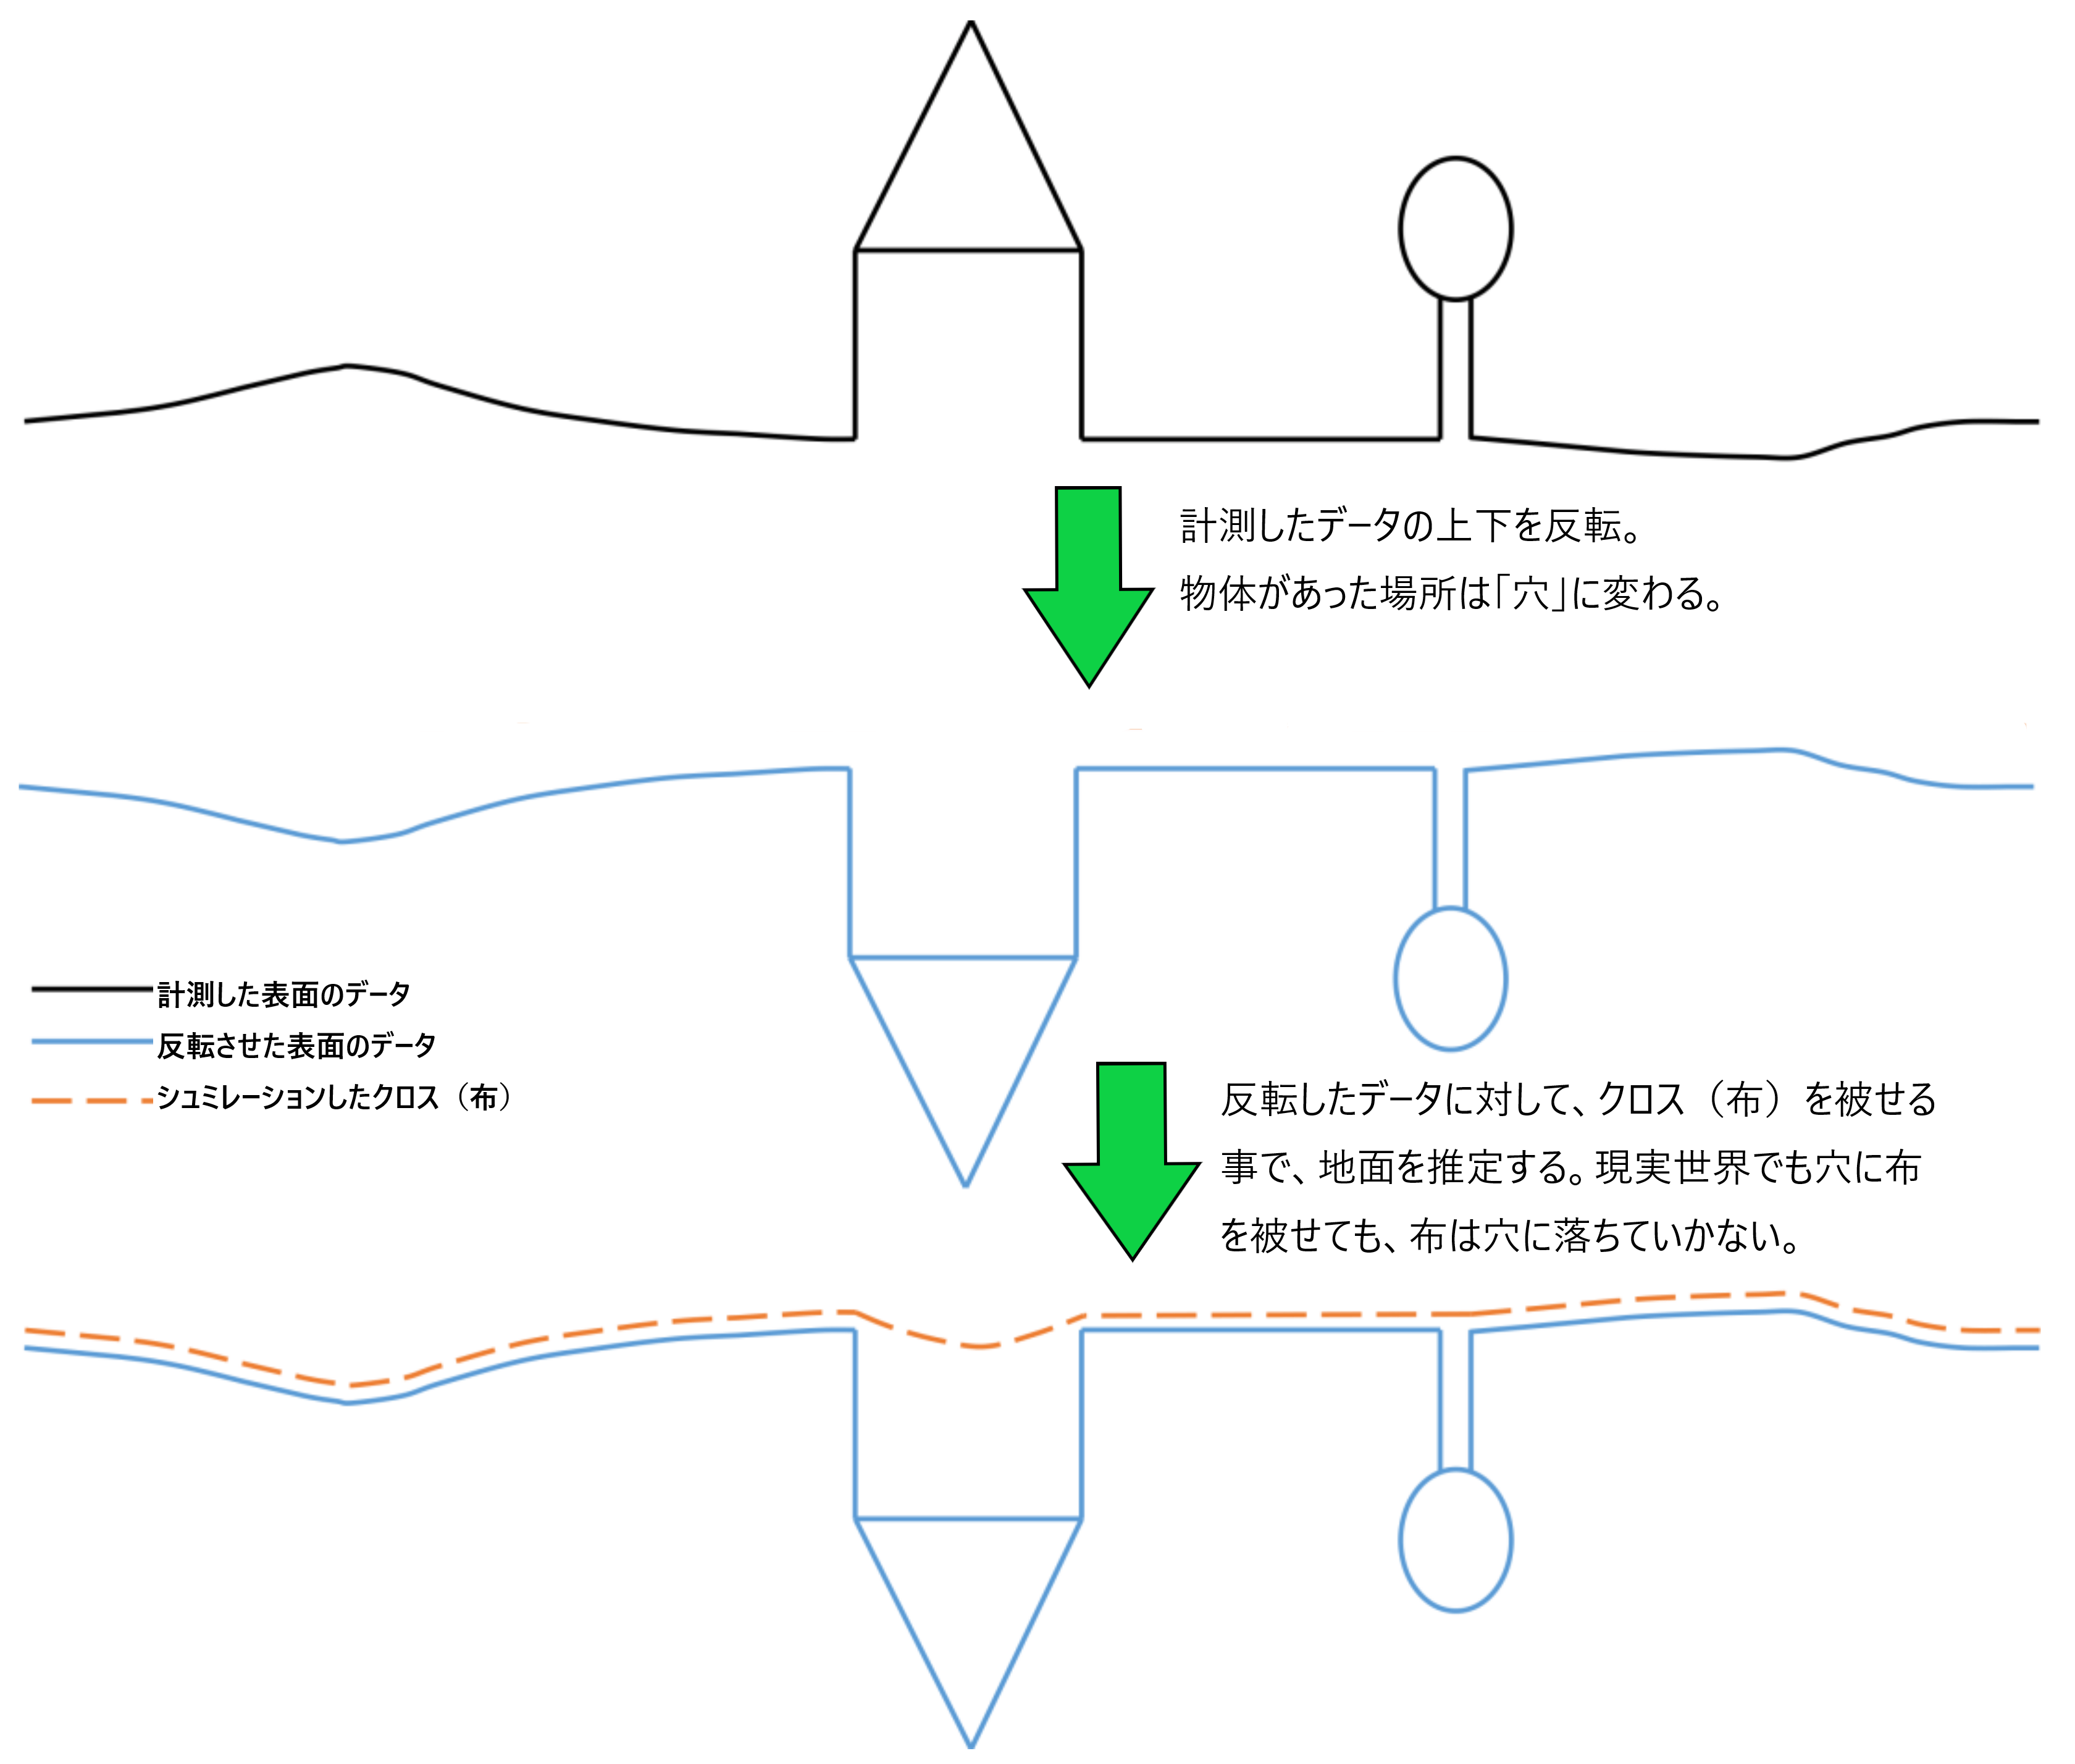

In [88]:
Image(r"F:\TEMP_FILE_STRAGE\LearnLidarData\images\Image of ClothSimulationFilter.jpg", width=600)